# mapbox_travel_times
This notebook demonstrates how to add MapBox travel times to your graph. You will need to enter your MapBox private key.

In [43]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Get reference to GOSTNets on local machine
sys.path.append(r'../../../GOSTnets')
import GOSTnets as gn

In [46]:
# define output folder
inputFolder = r'./input_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [47]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    # retrieve roads from OSMNX
    # https://stackoverflow.com/questions/58386781/osmnx-how-can-i-filter-the-the-highway-type
    ox.config(use_cache=True, log_console=True)
    # north, south, east, west
    custom_filter = '["highway"~"trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|motorway"]'
    # larger area
    # G = ox.graph_from_bbox(38.9271,38.8188,-77.0563,-77.4676, network_type=None, simplify=True, infrastructure='way["highway"]', custom_filter=custom_filter)
    # smaller area
    G = ox.graph_from_bbox(38.86,38.82,-77.339,-77.460, network_type=None, simplify=True, infrastructure='way["highway"]', custom_filter=custom_filter)
    print('print G before')
    print(G.size())
    # save the largest subgraph for networkX 2.4
    largest = max(nx.strongly_connected_components(G), key=len)
    G = nx.induced_subgraph(G,largest).copy()
    print('print G after')
    print(G.size())
    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

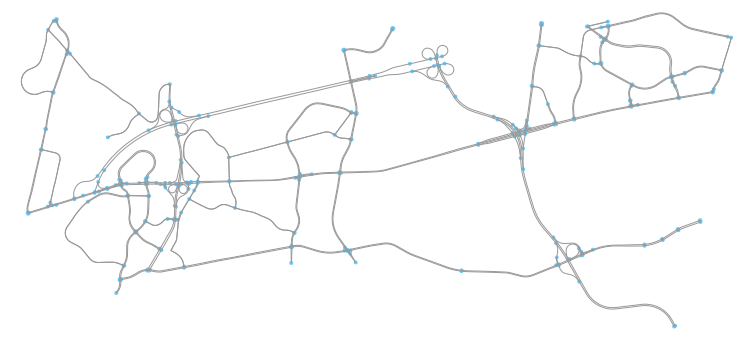

(<Figure size 1255.22x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13eb5f550>)

In [48]:
ox.plot_graph(G)

In [7]:
G.number_of_edges()

562

In [8]:
# testing
# edges_all = gn.edge_gdf_from_graph(G)
# edges_all[:5]

## Add MapBox travel times to the graph
This function will add average travel times to each edge

In [10]:
# To load environment file from a .ENV file, make sure that python-dotenv is installed
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [28]:
G = gn.assign_traffic_times(G, os.getenv("MAPBOX_TOKEN"), verbose = True, road_col = 'highway', id_col = 'osmid')

print unique roads
['secondary' 'motorway_link' 'tertiary' 'secondary_link' 'trunk'
 'trunk_link' 'motorway' 'tertiary_link']
print accepted_road_types
['trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 'motorway', 'motorway_link']
Did 300 calls in 30.87 seconds, now wait 29.13, 53.38% complete
complete function time: 87.46283388137817


In [29]:
# testing
roads = gn.edge_gdf_from_graph(G)
roads[:5]

,stnode,endnode,osmid,maxspeed,ref,lanes,highway,oneway,time_mapbox,length,time,access,bridge,mode,name,mapbox_api,geometry
0,660080642,660080660,637393246,45 mph,SR 620,2,secondary,True,11.1,12.473,1.49676,NaN,NaN,drive,Braddock Road,True,"LINESTRING (-77.36445 38.82951, -77.36459 38.8..."
1,660080642,506639824,8803585,NaN,NaN,NaN,motorway_link,True,5.9,37.967,3.03736,NaN,NaN,drive,NaN,True,"LINESTRING (-77.36445 38.82951, -77.36449 38.8..."
2,1420604423,63500390,8823532,NaN,SR 8349,NaN,tertiary,False,61.5,11.747,1.40964,NaN,NaN,drive,Upperridge Drive,True,"LINESTRING (-77.43716 38.83379, -77.43703 38.8..."
3,1420604423,5853797822,8815492,NaN,NaN,NaN,tertiary,True,59.0,198.088,23.77056,NaN,NaN,drive,Centerwood Drive,True,"LINESTRING (-77.43716 38.83379, -77.43739 38.8..."
4,1420604427,63497161,235560191,NaN,NaN,2,tertiary,True,40.8,12.007,1.44084,NaN,NaN,drive,Machen Road,True,"LINESTRING (-77.43879 38.83239, -77.43871 38.8..."


In [30]:
# Start point is Centreville, VA
# Point(x, y)
origin = Point(-77.432, 38.83)

# end point to use for bigger graph: Rosslyn, VA
# destination = Point(-77.071, 38.896)

# Fairfax mall
destination = Point(-77.36, 38.86)

In [31]:
snapped_origin = gn.pandana_snap_single_point(G, origin)

In [32]:
snapped_origin

548264224

In [33]:
snapped_destination = gn.pandana_snap_single_point(G, destination)

In [34]:
snapped_destination

599895127

In [35]:
# using NetworkX to calculate the shortest path between two nodes
route = nx.shortest_path(G, snapped_origin, snapped_destination, weight = 'time')

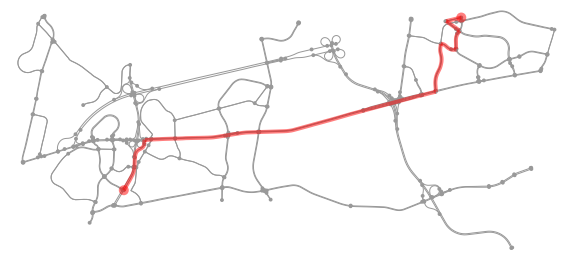

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13eb17400>)

In [36]:
ox.plot_graph_route(G, route, fig_height=10, fig_width=10)

In [37]:
default_distance = nx.dijkstra_path_length(G, snapped_origin, snapped_destination, weight = 'time')

In [38]:
default_distance

813.1230691428572

In [39]:
mapbox_route = nx.shortest_path(G, snapped_origin, snapped_destination, weight = 'time_mapbox')

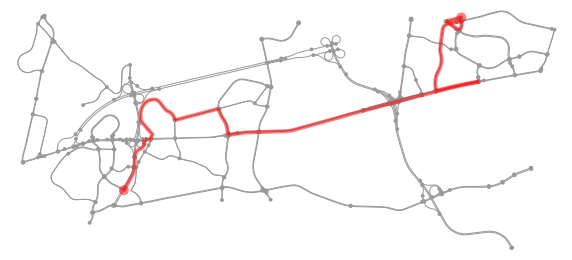

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13ebba640>)

In [40]:
ox.plot_graph_route(G, mapbox_route, fig_height=10, fig_width=10)

In [41]:
mapbox_distance = nx.dijkstra_path_length(G, snapped_origin, snapped_destination, weight = 'time_mapbox')

In [42]:
mapbox_distance

630.1